## Excitatory-inhibitory network (mode generic)
*Network as in Brunel (2000): https://doi.org/10.1023/a:1008925309027*

*Code partially based on the Brian 2 example here: https://brian2.readthedocs.io/en/stable/examples/frompapers.Brunel_2000.html*

#### Imports and definitions

In [1]:
import random
from brian2 import *
import brian2 as b2
print(f"Brian version: {b2.__version__}")
#BrianLogger.log_level_debug()
import matplotlib.pyplot as plt
from outputUtilities import getFormattedTime, getTimeDiff

# Standard value to scale model (variable can be used for fixed-pt. representation)
scf = 1

# Using Brian2Lava's standard model library and no specific library for other Lava processes
models_dir = None
lava_proc_dir = None

# Setting of parameters (see `parameters` dictionary)
selected_p_setting = "C" 

# Select target library -- is done to ensure comparability and avoid issues with Cython (Brian2Lava's preset mode 
# uses "numpy" as well)
prefs.codegen.target = "numpy"

Brian version: 2.7.1


#### Select the backend for Brian / Brian2Lava

In [2]:
# The following are options for `set_device` (see the documentation for a detailed description)
device = "lava" # can be "lava", "cpp_standalone", "runtime", etc.
b2l_mode = "preset" # can be "preset" or "flexible"
b2l_hardware = "CPU" # can be "CPU" or "Loihi2"
b2l_num_repr = "fixed" # can be "float" or "fixed"
b2l_use_f2f = False # can be True (to use F2F converter) or False (to not use it)
b2l_variable_updating_disabled = True # can be True (to disable updating to the final values) or False

#### Import Brian2Lava, set device, and prepare model (if required)

Brian2Lava version: 1.0.0b2

Preset LIF model with voltage input and refractory period:



Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
lif_rp_delta_v_input                                                            


Description                                                                     
--------------------------------------------------------------------------------
Leaky Integrate-and-Fire neuron with refractory period and delta-shaped voltage input


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


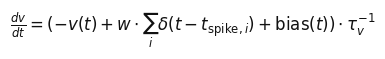

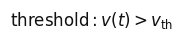

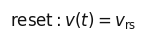



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dv/dt = (-v + bias)/tau_v : volt (unless refractory)                            
bias : volt                                                                     


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_th                                                                   
rs : v = v_rs                                                                   


Refractory period                                                               
--------------------------------------------------------------------------------
<supported>


Variables                                                                       
--------------------------------------------------------------------------------
+-------



Brian 2 equations                                                               
--------------------------------------------------------------------------------
rnd = rand() : 1 (constant over dt)                                             
p_spike : 1                                                                     


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : rnd < p_spike                                                              
rs :                                                                            


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Variables                                                                       
--------------------------------------------------------------------------------
+---

In [3]:
# Using Brian2Lava device in Brian
if device == "lava":
    # Import Brian2Lava
    import brian2lava
    print(f"Brian2Lava version: {brian2lava.__version__}\n")
    # Select external models directory if Loihi 2 hardware is used
    # (replace this by your directory with ncProcessModels)
    if b2l_hardware == "Loihi2":
        models_dir = "/homes/jlubo/brian2lava-models/models"
        lava_proc_dir = "/homes/jlubo/brian2lava-models/lava_proc"
    # Set device
    set_device("lava", mode=b2l_mode, hardware=b2l_hardware, num_repr=b2l_num_repr, models_dir=models_dir,
               lava_proc_dir=lava_proc_dir, use_f2f=b2l_use_f2f, variable_updating_disabled=b2l_variable_updating_disabled)
    # Prepare model (LIF model with voltage input) and print further information if in preset mode
    if b2l_mode == "preset":
        from brian2lava.preset_mode.model_loader import lif_rp_delta_v_input
        print(80*"=")
        print("Preset LIF model with voltage input and refractory period:\n\n\n")
        # Show model information
        lif_rp_delta_v_input.show()
        # This is a Brian `Equations` object of the equations:
        # lif_rp_delta_v_input.equations
        # This is a ready-to-plug version of the equations:
        # lif_rp_delta_v_input.string_equations
        # This is a dictionary of the other conditions:
        # lif_rp_delta_v_input.conditions
        from brian2lava.preset_mode.model_loader import probspiker
        print(80*"=")
        print("Preset probabilistic spiker neuron:\n\n\n")
        # Show model information
        probspiker.show()
        # This is a Brian `Equations` object of the equations:
        # probspiker.equations
        # This is a ready-to-plug version of the equations:
        # probspiker.string_equations
        # This is a dictionary of the other conditions:
        # probspiker.conditions
        print(80*"=")
        # Set scaling factors for fixed-point computation --- TODO
        if b2l_num_repr == "fixed":
            scf = 1e4
# Using other device in Brian
else:
    # Set device
    set_device(device)

#### Available parameter settings (from Brunel, 2000)

In [4]:
# Define the parameter settings for simulation and plotting

parameters = {
    "A": {
        "g": 3,
        "nu_ext_over_nu_thr": 2,
        "t_range": [500, 600],
        "state_range": [],
        "state_tick_step": 1000,
        "spike_raster_index_range": [0, 50],
    },
    "B": {
        "g": 6,
        "nu_ext_over_nu_thr": 4,
        "t_range": [1000, 1200],
        "state_range": [],
        "state_tick_step": 100,
        "spike_raster_index_range": [0, 50],
    },
    "C": {
        "g": 5,
        "nu_ext_over_nu_thr": 2,
        "t_range": [1000, 1200],
        "state_range": [],
        "state_tick_step": 50,
        "spike_raster_index_range": [0, 50],
    },
    "D": {
        "g": 4.5,
        "nu_ext_over_nu_thr": 0.9,
        "t_range": [1000, 1200],
        "state_range": [],
        "state_tick_step": 50,
        "spike_raster_index_range": [0, 50],
    },
}

#### Simulation function

In [5]:
def sim(params):
    """
    Simulates the excitatory-inhibitory network
    
    Parameters
    ----------
    params
        all parameters for the simulation and plotting
        
    Returns
    -------
    spike_monitor
        spike monitor object that records the spikes during the simulation
    state_monitor_v 
        state monitor object that records the voltage state during the simulation
    """
    
    # Print headline
    print(80*"=")
    print(f"Device: {get_device()}")
    print(80*"=")
    
    # Measure time before simulation setup
    t_0, _ = getTimeDiff()
    
    # Simulation parameters
    defaultclock.dt = 0.1 * ms*scf                    # duration of one timestep
    sim_time = params["t_range"][1] * ms*scf          # total simulation time  
    num_timesteps = int(sim_time / defaultclock.dt)   # total number of timesteps
    #seed(0)                                          # random seed
    
    # Network parameters
    N_E = 100                        # number of excitatory neurons --- SHALL BE 10000 FOR ORIGINAL MODEL, BUT ATM THERE WOULD BE MEMORY ISSUES
    gamma = 0.25                     # relative inhibitory to excitatory population size
    N_I = round(gamma * N_E)         # number of inhibitory neurons
    N = N_E + N_I                    # total number of neurons
    epsilon = 0.1                    # probability of connection
    C_E = epsilon * N_E              # average count of incoming excitatory connections
    C_ext = C_E                      # average count of external inputs

    # Neuron parameters
    tau_v = 20 * ms*scf            # membrane time constant
    # tau_j = defaultclock.dt       # postsynaptic current time constant (approx. =0*ms -- B2L would support 0*ms as well, but pure Brian doesn't)
    #tau_psp = defaultclock.dt      # postsynaptic potential time constant (approx. =0*ms -- B2L would support 0*ms as well, but pure Brian doesn't)
    V_th = 20 * mV*scf             # threshold potential
    V_rs = 10 * mV*scf             # reset potential
    t_rp = 2 * ms*scf              # refractory period
        
    # Synapse parameters
    g = params["g"]                     # relative inhibitory to excitatory synaptic strength
    J = 0.1 * mV*scf                    # strength constant
    J_exc = J                           # strength of excitatory synapses
    J_inh = -g*J                        # strength of inhibitory synapses
    J_inp = J                           # strength of input synapses
    D = 1.5 * ms*scf                    # synaptic delay

    # External stimulation
    nu_ext_over_nu_thr = params["nu_ext_over_nu_thr"]  # ratio of external stimulus rate to threshold rate
    nu_thr = V_th / (J * C_E * tau_v)                  # threshold rate
    nu_ext = nu_ext_over_nu_thr * nu_thr               # external stimulus
    #bias = 0.0002 * mV/ms*scf                         # bias current added to every neuron
    bias = 0 * mV/ms*scf                               # bias current added to every neuron
    #print(f"C_ext = {C_ext}, nu_ext = {nu_ext}, weight = {J_inp}")
    
    # LIF equations with exponential PSCs (current input)
    #equations = """dj/dt = -j/tau_j : volt/second
    #               dv/dt = -v/tau_v + j + bias : volt (unless refractory)"""
    
    # LIF equations with exponential PSPs (voltage input)
    #equations = """dv_psp/dt = -v_psp/tau_psp : volt
    #               dv/dt = (-v + v_psp + bias)/tau_v : volt (unless refractory)
    #               bias : volt"""
    
    # LIF equations with delta PSPs (voltage input)
    equations = """dv/dt = (-v + bias)/tau_v : volt (unless refractory)
                   bias : volt"""
    excitatory_neurons = NeuronGroup(N_E,
                          equations,
                          threshold="v > V_th",
                          reset="v = V_rs",
                          refractory=t_rp,
                          method="exact",
    )
    excitatory_neurons.v = V_rs
    inhibitory_neurons = NeuronGroup(N_I,
                          equations,
                          threshold="v > V_th",
                          reset="v = V_rs",
                          refractory=t_rp,
                          method="exact",
    )
    inhibitory_neurons.v = V_rs
    # Adding synaptic input to membrane potentials in accordance with preset model (weight is added directly to `v` to obtain delta-shaped PSPs, 
    # which are otherwise not supported by pure Brian 2)
    ee_synapses = Synapses(excitatory_neurons, target=excitatory_neurons, model = 'w : volt', on_pre="v_post += w", delay=D)
    ee_synapses.connect(p=epsilon)
    ee_synapses.w = J_exc
    ei_synapses = Synapses(excitatory_neurons, target=inhibitory_neurons, model = 'w : volt', on_pre="v_post += w", delay=D)
    ei_synapses.connect(p=epsilon)
    ei_synapses.w = J_exc
    ie_synapses = Synapses(inhibitory_neurons, target=excitatory_neurons, model = 'w : volt', on_pre="v_post += w", delay=D)
    ie_synapses.connect(p=epsilon)
    ie_synapses.w = J_inh
    ii_synapses = Synapses(inhibitory_neurons, target=inhibitory_neurons, model = 'w : volt', on_pre="v_post += w", delay=D)
    ii_synapses.connect(p=epsilon)
    ii_synapses.w = J_inh
    """
    # Adding external Poisson stimulation via `PoissonInput` -- not supported by Brian2Lava yet
    ext_inp_e_synapses = PoissonInput(
        target=excitatory_neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J_inp
    )
    ext_inp_i_synapses = PoissonInput(
        target=inhibitory_neurons, target_var="v", N=C_ext, rate=nu_ext, weight=J_inp
    )
    """
    
    """
    # Adding external Poisson stimulation via `SpikeGeneratorGroup`
    p_spike_0 = np.clip(nu_ext * defaultclock.dt, 0, 1)  # spiking probability per time bin
    C_ext = int(C_ext)  # make number of external inputs an integer
    spiking_bin = np.random.rand(C_ext*N, num_timesteps) < p_spike_0  # generate spike trains for `C_ext*N` input neurons
    spike_indices, spike_times = np.nonzero(spiking_bin)  # extract spike times and indices
    sg = SpikeGeneratorGroup(C_ext*N, spike_indices, spike_times*defaultclock.dt)
    ext_inp_e_synapses = Synapses(sg, excitatory_neurons, model = 'w : volt', on_pre='v += w')
    ext_inp_e_synapses.connect(j="i%N_E if i<C_ext*N_E")  # connect every `C_ext`-th neuron to postsynaptic neuron `j`
    ext_inp_e_synapses.w = J_inp
    ext_inp_i_synapses = Synapses(sg, inhibitory_neurons, model = 'w : volt', on_pre='v += w')
    ext_inp_i_synapses.connect(j="(i-C_ext*N_E)%N_I if i>=C_ext*N_E")
    ext_inp_i_synapses.w = J_inp
    if np.sum(ext_inp_e_synapses.N_outgoing_pre) != np.sum(ext_inp_e_synapses.N_incoming_post) or np.sum(ext_inp_e_synapses.N_outgoing_pre) != C_ext*N_E:
        raise Exception(f"Wrong number of synaptic connections in 'ext_inp_e_synapses': {np.sum(ext_inp_e_synapses.N_outgoing_pre)} outgoing, "
                        f"{C_ext*np.sum(ext_inp_e_synapses.N_incoming_post)} incoming, C_ext*N_E = {C_ext*N_E}.")
    if np.sum(ext_inp_i_synapses.N_outgoing_pre) != np.sum(ext_inp_i_synapses.N_incoming_post) or np.sum(ext_inp_i_synapses.N_outgoing_pre) != C_ext*N_I:
        raise Exception(f"Wrong number of synaptic connections in 'ext_inp_i_synapses': {np.sum(ext_inp_i_synapses.N_outgoing_pre)} outgoing, "
                        f"{C_ext*np.sum(ext_inp_i_synapses.N_incoming_post)} incoming, C_ext*N_I = {C_ext*N_I}.")

    """
    # Adding external Poisson stimulation via `NeuronGroup` (surrogate for `PoissonGroup`; cf. https://brian2.readthedocs.io/en/2.5.4/user/input.html#more-on-poisson-inputs)
    p_spike_0 = np.clip(nu_ext * defaultclock.dt, 0, 1)  # spiking probability per time bin
    print(f"p_spike_0 = {p_spike_0}")
    C_ext = int(C_ext)  # make number of external inputs an integer
    inp_equations = "rnd = rand() : 1 (constant over dt)\np_spike : 1"
    ext_inp_e_neurons = NeuronGroup(C_ext*N_E, inp_equations, threshold='rnd < p_spike', reset='')
    ext_inp_i_neurons = NeuronGroup(C_ext*N_I, inp_equations, threshold='rnd < p_spike', reset='')
    """
    ext_inp_e_neurons = NeuronGroup(C_ext*N_E,
                          equations,
                          threshold="v > V_th",
                          reset="v = V_rs",
                          refractory=t_rp,
                          method="exact",
    )
    ext_inp_i_neurons = NeuronGroup(C_ext*N_I,
                          equations,
                          threshold="v > V_th",
                          reset="v = V_rs",
                          refractory=t_rp,
                          method="exact",
    )
    """
    ext_inp_e_neurons.p_spike = p_spike_0
    ext_inp_i_neurons.p_spike = p_spike_0
    ext_inp_e_synapses = Synapses(ext_inp_e_neurons, excitatory_neurons, model = 'w : volt', on_pre='v_post += w')  # synaptic connection, accounting for random spiking of 0 to `C_ext` input neurons
    ext_inp_e_synapses.connect(j="i%N_E")
    ext_inp_e_synapses.w = J_inp
    ext_inp_i_synapses = Synapses(ext_inp_i_neurons, inhibitory_neurons, model = 'w : volt', on_pre='v_post += w')
    ext_inp_i_synapses.connect(j="i%N_I")
    ext_inp_i_synapses.w = J_inp
    if np.sum(ext_inp_e_synapses.N_outgoing_pre) != np.sum(ext_inp_e_synapses.N_incoming_post) or np.sum(ext_inp_e_synapses.N_outgoing_pre) != C_ext*N_E:
        raise Exception(f"Wrong number of synaptic connections in 'ext_inp_e_synapses': {np.sum(ext_inp_e_synapses.N_outgoing_pre)} outgoing, "
                        f"{C_ext*np.sum(ext_inp_e_synapses.N_incoming_post)} incoming, C_ext*N_E = {C_ext*N_E}.")
    if np.sum(ext_inp_i_synapses.N_outgoing_pre) != np.sum(ext_inp_i_synapses.N_incoming_post) or np.sum(ext_inp_i_synapses.N_outgoing_pre) != C_ext*N_I:
        raise Exception(f"Wrong number of synaptic connections in 'ext_inp_i_synapses': {np.sum(ext_inp_i_synapses.N_outgoing_pre)} outgoing, "
                        f"{C_ext*np.sum(ext_inp_i_synapses.N_incoming_post)} incoming, C_ext*N_I = {C_ext*N_I}.")

    # Record spikes from the first 50 excitatory neurons
    #spike_monitor = SpikeMonitor(excitatory_neurons)
    if b2l_hardware == "":
        spike_monitor = None # TODO
    else:
        #spike_monitor = SpikeMonitor(excitatory_neurons[params["spike_raster_index_range"][0]:params["spike_raster_index_range"][1]]) #--- DOES NOT WORK YET IN B2L
        spike_monitor = SpikeMonitor(excitatory_neurons)
    
    # Record membrane potential from the first neuron
    state_monitor_v = StateMonitor(excitatory_neurons, variables='v', record=[0])
    
    # Measure time after simulation setup
    t_1, t_diff = getTimeDiff(t_0)
    print("Time elapsed while setting up the simulation: " + getFormattedTime(round(t_diff)) + ".")

    # Run the simulation
    run(sim_time, report='text')
    
    # Measure time after the simulation has run
    t_2, t_diff = getTimeDiff(t_1)
    print("Time elapsed while running the simulation: " + getFormattedTime(round(t_diff)) + ".")
    
    return spike_monitor, state_monitor_v, excitatory_neurons, inhibitory_neurons

#### Plotting function

In [6]:
def plot(params, spike_monitor, state_monitor_v):
    """
    Plots the spike raster of a group of neurons and the voltage trace on one neuron
    
    Parameters
    ----------
    params
        all parameters for the simulation and plotting
    spike_monitor
        spike monitor object that recorded the spikes during the simulation
    state_monitor_v 
        state monitor object that recorded the voltage state during the simulation
    """
    fig = plt.figure(figsize=(8, 5))

    # Subplot grid specification
    if spike_monitor is not None:
        gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[4, 2])
        ax_spikes, ax_state = gs.subplots(sharex="col")
    else:
        gs = fig.add_gridspec(ncols=1, nrows=1, height_ratios=[2])
        ax_state = gs.subplots(sharex="col")
    
    # Spike raster plot
    if spike_monitor is not None:
        ax_spikes.set_title(f'Excitatory population, neurons {params["spike_raster_index_range"]}')
        
        # Plot (VariableView objects need to be converted to NumPy arrays)
        t = np.array(spike_monitor.t)/(scf*ms)
        indices = np.array(spike_monitor.i)
        ax_spikes.plot(t, indices, "|")
        
        ax_spikes.set_xlim(*params["t_range"])
        ax_spikes.set_ylim(*params["spike_raster_index_range"])
        
        ax_spikes.set_ylabel('Neuron index')
    
    # Voltage plot
    ax_state.set_title('Excitatory population, neuron 0')
    ax_state.plot(state_monitor_v.t/(scf*ms), state_monitor_v.v[0]/(scf*mV), color="#ff0000", label='Voltage')
    
    ax_state.set_xlim(*params["t_range"])
    ax_state.set_ylim(*params["state_range"])
    
    ax_state.set_xlabel("Time (ms)")
    ax_state.set_ylabel('Membrane voltage (mV)')

    plt.subplots_adjust(hspace=0)
    plt.tight_layout()

#### Run and plot the given simulation

In [7]:
spike_monitor, state_monitor_v, excitatory_neurons, inhibitory_neurons = sim(parameters[selected_p_setting])

Device: <brian2lava.device.LavaDevice object at 0x7f2694b277c0>
p_spike_0 = 0.2


WARNING    [EFFICIENCY]: Recording specific indices is not supported by Lava natively. In Brian2Lava, the specified 
        indices are only considered when using spike monitors on Loihi 2 (this is an additional feature compared to Brian 2, 
        where the 'record' parameter only accepts boolean values). Otherwise, all elements are monitored regardless of the 
        specified indices, and filtering is done only as a post-processing step - thus, no performance gain will come from it. [brian2.devices.lava]


Time elapsed while setting up the simulation: <1 s.


WARNING    'bias' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0. * volt / second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'bias' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0. * volt / second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       Selected preset model 'lif_rp_delta_v_input' for 'neurongroup'. [brian2.devices.lava]
WARNING    Cannot state with certainty that the selected preset model implements the right ['th', 'rs'] conditions (values provided by you: [['v > V_th'], ['v = V_rs']]). If you want to avoid this warning, make sure that you use the exact same expressions for the conditions of your neuron group as those provided with the preset model (call `lif_rp_delta_v_input.conditions` to see them). [brian2.devices.lava]
INFO       Encountered variab

Time elapsed while running the simulation: 1 m 33 s.


In [8]:
plot(parameters[selected_p_setting], spike_monitor, state_monitor_v)

#### Number of spikes in the selected range

In [9]:
if spike_monitor is not None:
    print("Total sum of spikes in considered range:", 
          np.sum(np.logical_and(spike_monitor.i >= parameters[selected_p_setting]["spike_raster_index_range"][0],
                 spike_monitor.i < parameters[selected_p_setting]["spike_raster_index_range"][1])))
    print("Sum of spikes in neuron #30:", np.sum((spike_monitor.i == 30)))
    print("Sum of spikes in neuron #31:", np.sum((spike_monitor.i == 31)))

Total sum of spikes in considered range: 4815
Sum of spikes in neuron #30: 88
Sum of spikes in neuron #31: 103


In [10]:
print(f"v_0(t_steps=0) = {state_monitor_v.v[0][0]/scf}")
print(f"v_0(t_steps=10) = {state_monitor_v.v[0][10]/scf}")
print(f"v_0(t_steps={len(state_monitor_v.v[0])}) = {state_monitor_v.v[0][-1]/scf}")
if b2l_variable_updating_disabled:
    print(f"excitatory_neurons.v[0] = {excitatory_neurons.v[0]/scf} (initial value)")
else:
    print(f"excitatory_neurons.v[0] = {excitatory_neurons.v[0]/scf} (final value)")

v_0(t_steps=0) = 10. mV
v_0(t_steps=10) = 10.8 mV
v_0(t_steps=12000) = 19.8 mV
excitatory_neurons.v[0] = 10. mV (initial value)


In [11]:
#print(f"spikes(i=0) = {np.sum(spike_monitor.i == 0)}")
#print(f"spikes(i=25) = {np.sum(spike_monitor.i == 25)}")